<a href="https://colab.research.google.com/github/kimhwijin/korean_food_classifier/blob/master/korean_food_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip Dataset

In [ ]:
import time

start = time.time()
!unzip -qq "drive/MyDrive/Datasets/kfood.zip"
end = time.time()
print((end-start) // 60, "분...")

6.0 분...


#Clone github

In [ ]:
!git clone https://github.com/kimhwijin/korean_food_classifier.git

Cloning into 'korean_food_classifier'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 297 (delta 164), reused 215 (delta 92), pack-reused 0
Receiving objects: 100% (297/297), 9.65 MiB | 23.98 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [ ]:
import sys
import os
sys.path.append(os.getcwd() + '/korean_food_classifier')

In [ ]:
import kfood_dataset

batch_size = 32
randomize = True #random crop variable
paths = kfood_dataset.get_image_paths()

dataset path : /content/kfood True
making class to label txt file...
saving classes, labels...
saving crop information...
ready!
finding image paths...
shuffling...
paths ready!


# Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make Train, Valid, Test, Dataset

In [ ]:
# train : 0.64, test : 0.2, valid : 0.16
train_paths_full, test_paths = train_test_split(paths, test_size=0.2)
train_paths, valid_paths = train_test_split(train_paths_full, test_size=0.2)

In [ ]:
train_set = kfood_dataset.make_kfood_dataset(train_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=len(paths[30000:]) // batch_size, randomize=randomize)
valid_set = kfood_dataset.make_kfood_dataset(valid_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=10000 // batch_size, randomize=randomize)
test_set = kfood_dataset.make_kfood_dataset(test_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=1, randomize=False)

# Plot samples

tf.Tensor([[128]], shape=(1, 1), dtype=int64)
tf.Tensor([[37]], shape=(1, 1), dtype=int64)
tf.Tensor([[83]], shape=(1, 1), dtype=int64)
tf.Tensor([[15]], shape=(1, 1), dtype=int64)


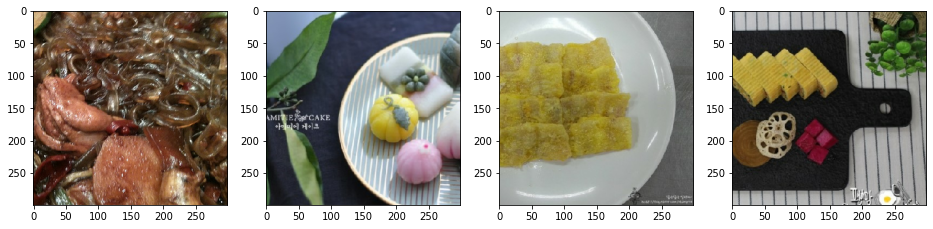

In [ ]:
kfood_dataset.plot_dataset_image_4(train_set)

# Model Saver

In [10]:
import matplotlib.pyplot as plt
import numpy as np

class ModelSaver(keras.callbacks.Callback):
    def __init__(self, now, model_paths,**kwargs):
        self.now = now
        self.model_paths = model_paths
        self.loss = np.array([])
    
    def on_epoch_end(self, epoch, logs={}):
        fileformats = [self.now.year, self.now.month, self.now.day, self.now.hour, self.now.minute, epoch]
        self.model.save(self.model_paths + "/{}_{}_{}_{}_{}_{}.hd5".format(*fileformats))
        
        self.loss = np.append(self.loss, logs["loss"])
        plt.plot(np.arange(1, epoch+2), self.loss)
        plt.axis([1, 10, 1, self.loss[0]+0.5])
        plt.savefig(self.model_paths + "/loss.png", format="png", dpi=300)
        


# Model Train With Pretrained Model

In [ ]:
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=[299,299,3])
avg = keras.layers.GlobalAvgPool2D()(base_model.output)
output = keras.layers.Dense(150, activation='softmax')(avg)

model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.summary()

# BaseLayer Freeze

In [ ]:
# freeze
for layer in base_model.layers:
    layer.trainable = False

# Compile and Train

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=5)

Epoch 1/5
3765/3765 [==============================] - 789s 201ms/step - loss: 1.9645 - accuracy: 0.5206 - val_loss: 1.5937 - val_accuracy: 0.5800
Epoch 2/5
3765/3765 [==============================] - 751s 199ms/step - loss: 1.5099 - accuracy: 0.6019 - val_loss: 1.5502 - val_accuracy: 0.5931
Epoch 3/5
3765/3765 [==============================] - 753s 200ms/step - loss: 1.4439 - accuracy: 0.6198 - val_loss: 1.5046 - val_accuracy: 0.6044
Epoch 4/5
3765/3765 [==============================] - 750s 199ms/step - loss: 1.4117 - accuracy: 0.6307 - val_loss: 1.4977 - val_accuracy: 0.6137
Epoch 5/5
3765/3765 [==============================] - 754s 200ms/step - loss: 1.3901 - accuracy: 0.6347 - val_loss: 1.4925 - val_accuracy: 0.6098


In [ ]:
#save connacted pretrained and new model
now = datetime.datetime.now()
fileformats = [now.year, now.month, now.day, now.hour, now.minute]
model.save(model_paths + "stem_{}_{}_{}_{}_{}.hd5".format(*fileformats))

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5/assets


# Load Connected Weight Model

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5")

# Check Weights With Evaluate

In [ ]:
model.evaluate(valid_set, steps=10000 // 32)

312/312 [==============================] - 64s 191ms/step - loss: 1.4889 - accuracy: 0.6132


[1.4888681173324585, 0.6131811141967773]

# Release Layers

In [ ]:
#release
for layer in model.layers[:-2]:
    layer.trainable = True

# Compile and Train

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=40,
          callbacks=[ModelSaver(datetime.datetime.now(), model_paths.format(model_name))]
          )

Epoch 1/40
3765/3765 [==============================] - 2326s 606ms/step - loss: 0.7652 - accuracy: 0.7866 - val_loss: 0.6133 - val_accuracy: 0.8289
Epoch 2/40
3765/3765 [==============================] - 2285s 607ms/step - loss: 0.3556 - accuracy: 0.9014 - val_loss: 0.5375 - val_accuracy: 0.8478
Epoch 3/40
3765/3765 [==============================] - 2283s 606ms/step - loss: 0.2173 - accuracy: 0.9421 - val_loss: 0.5122 - val_accuracy: 0.8574
Epoch 4/40
3765/3765 [==============================] - 2294s 609ms/step - loss: 0.1462 - accuracy: 0.9643 - val_loss: 0.5131 - val_accuracy: 0.8607
Epoch 5/40
3765/3765 [==============================] - 2291s 609ms/step - loss: 0.1071 - accuracy: 0.9766 - val_loss: 0.5108 - val_accuracy: 0.8625
Epoch 6/40
3765/3765 [==============================] - 2284s 607ms/step - loss: 0.0840 - accuracy: 0.9833 - val_loss: 0.5136 - val_accuracy: 0.8622
Epoch 7/40
3765/3765 [==============================] - 2280s 606ms/step - loss: 0.0675 - accuracy: 0.9879

KeyboardInterrupt: ignored

# Custom Inception ResNet Model

In [ ]:
from application.inception_resnet_v2 import InceptionResNetV2

inception = InceptionResNetV2()
inception.summary()

# Custom Model Compile

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
inception.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Custom Model Train and Save

In [ ]:
from datetime import datetime
model_paths = "drive/MyDrive/Model/kfood/{}/{}"
model_name = "CustomInceptionResNetV2"
train_property = "SGD_Random"

model_saver = ModelSaver(datetime.now(), model_paths.format(model_name, train_property))
bestmodel_saver = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_paths.format(model_name, train_property) + "/best",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = inception.fit(train_set, steps_per_epoch=len(train_paths)//batch_size,
          validation_data=valid_set, validation_steps=len(valid_paths) // batch_size, 
          epochs=40,
          callbacks=[model_saver, bestmodel_saver]
          )

Epoch 1/40
3765/3765 [==============================] - 2299s 602ms/step - loss: 2.9105 - accuracy: 0.2950 - val_loss: 2.3817 - val_accuracy: 0.3895
Epoch 2/40
3765/3765 [==============================] - 2265s 602ms/step - loss: 1.8187 - accuracy: 0.5212 - val_loss: 1.7701 - val_accuracy: 0.5244
Epoch 3/40
3765/3765 [==============================] - 2264s 601ms/step - loss: 1.4773 - accuracy: 0.6062 - val_loss: 1.5156 - val_accuracy: 0.5881
Epoch 4/40
3765/3765 [==============================] - 2265s 602ms/step - loss: 1.2841 - accuracy: 0.6544 - val_loss: 1.4387 - val_accuracy: 0.6001
Epoch 5/40
3765/3765 [==============================] - 2268s 602ms/step - loss: 1.1502 - accuracy: 0.6878 - val_loss: 1.3425 - val_accuracy: 0.6259
Epoch 6/40
3765/3765 [==============================] - 2263s 601ms/step - loss: 1.0439 - accuracy: 0.7177 - val_loss: 1.3880 - val_accuracy: 0.6182
Epoch 7/40
3765/3765 [==============================] - 2265s 602ms/step - loss: 0.9492 - accuracy: 0.7427

In [ ]:
inception.evaluate(test_set, steps=len(test_paths))

312/312 [==============================] - 60s 189ms/step - loss: 0.3080 - accuracy: 0.9164


[0.30803391337394714, 0.9163661599159241]